In [318]:
name_gal="manga-7960-12704"
#name_gal="manga-7443-12702"

In [319]:
%matplotlib inline
import numpy as np
import pandas as pd
from pylab import *
import matplotlib
import plplot
from scipy import stats
#from io import StringIO
print(pd.__version__)
#AttributeError: 'Series' object has no attribute 'to_numpy'
import re

import math
import astropy as astro
import scipy.ndimage as spimage
from astropy.io import fits, ascii
from astropy.table import Table
from astropy.cosmology import WMAP9 as cosmo
import matplotlib as mpl
from numpy import std as biweight_midvariance
import matplotlib.cm as cm

from scipy import optimize
from scipy.stats import gaussian_kde
from matplotlib import colors



0.24.2


In [320]:
def make_colourmap(ind, red, green, blue, name):
    newInd = range(0, 256)
    r = np.interp(newInd, ind, red, left=None, right=None)
    g = np.interp(newInd, ind, green, left=None, right=None)
    b = np.interp(newInd, ind, blue, left=None, right=None)
    colours = np.transpose(np.asarray((r, g, b)))
    fctab= colours/255.0
    cmap = colors.ListedColormap(fctab, name=name,N=None)
    return cmap

def get_califa_velocity_cmap():
    ind = [1., 35., 90.,125.,160.,220.,255.]
    red = [148., 0., 0., 55.,221.,255.,255.]
    green = [ 0., 0.,191., 55.,160., 0.,165.]
    blue = [211.,128.,255., 55.,221., 0., 0.]
    return make_colourmap(ind, red, green, blue, 'califa_vel')


def get_califa_velocity_cmap_2():
    ind = [0., 1., 35., 90.,125.,160.,220.,255.]
    red = [ 0.,148., 0., 0., 55.,221.,255.,255.]
    green = [ 0., 0., 0.,191., 55.,160., 0.,165.]
    blue = [ 0.,211.,128.,255., 55.,221., 0., 0.]
    return make_colourmap(ind, red, green, blue, 'califa_vel')

def get_califa_intensity_cmap_2():
    ind = [ 0., 1., 50.,100.,150.,200.,255.]
    red = [ 0., 0., 0.,255.,255., 55.,221.]
    green =	[ 0., 0.,191., 0.,165., 55.,160.]
    blue = [ 0.,128.,255., 0., 0., 55.,221.]
    return make_colourmap(ind, red, green, blue, 'califa_int')


def get_califa_intensity_cmap():
    ind = [ 1., 50.,100.,150.,200.,255.]
    red = [ 0., 0.,255.,255., 55.,221.]
    green =	[ 0.,191., 0.,165., 55.,160.]
    blue = [ 128.,255., 0., 0., 55.,221.]
    return make_colourmap(ind, red, green, blue, 'califa_int')

#califa_vel = get_califa_velocity_cmap()
#califa_int = get_califa_intensity_cmap()
#califa_int=cm.nipy_spectral
califa_int=cm.Spectral
califa_vel=cm.Spectral




def fit_leastsq_pure(p0, datax, datay, function):

    errfunc = lambda p, x, y: function(x,p) - y

    pfit, pcov, infodict, errmsg, success = \
        optimize.leastsq(errfunc, p0, args=(datax, datay), \
                          full_output=1, epsfcn=0.0001)

    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, perr_leastsq 

def fit_leastsq(p0, datax, datay, function):

    errfunc = lambda p, x, y: function(x,p) - y

    pfit, pcov, infodict, errmsg, success = \
        optimize.leastsq(errfunc, p0, args=(datax, datay), \
                          full_output=1, epsfcn=0.01)
# epsfcn=0.0001)


    if (len(datay) > len(p0)) and pcov is not None:
        s_sq = (errfunc(pfit, datax, datay)**2).sum()/(len(datay)-len(p0))
        pcov = pcov * s_sq
    else:
        pcov = np.inf

    error = [] 
    for i in range(len(pfit)):
        try:
          error.append(np.absolute(pcov[i][i])**0.5)
        except:
          error.append( 0.00 )
    pfit_leastsq = pfit
    perr_leastsq = np.array(error) 
    return pfit_leastsq, pcov 



In [321]:
def binning_OH(M_OK, OH_Ref_OK, bin1 , min1 , max1 ):
    
    M_bin=[]
    OH_bin=[]
    D_OH_bin=[]
    
    OH_binM    = np.arange(min1,max1,bin1) 
    OH_binM = OH_binM-bin1*0.5
    m_range    = np.zeros(OH_binM.size)
    OH_binD    = np.zeros(OH_binM.size)

    for i, val  in enumerate(OH_binM):
        tmp = (OH_Ref_OK >= val) & (OH_Ref_OK <= val+bin1)
        m_sub=M_OK[tmp]
        n_vals=m_sub.size
        m_range[i]   = np.median(M_OK[tmp])
        OH_binD[i]   = np.std(OH_Ref_OK[tmp])
        print('n_val',n_val,', vals = ',M_OK[tmp])
        if (n_vals > 20):
            M_bin.append(m_range[i])
            OH_bin.append(OH_binM[i])
            D_OH_bin.append(OH_binD[i])
    m_range=np.array(M_bin)
    OH_binM=np.array(OH_bin)
    OH_binD=np.array(D_OH_bin)
        
    return(m_range, OH_binM, OH_binD)
    
def binning(M_OK, OH_Ref_OK, bin1 , min1 , max1 ):
    
    
    m_range = np.arange(min1,max1,bin1)
    M_binM    = np.zeros(m_range.size)
    M_binV    = np.zeros(m_range.size)
    OH_binM    = np.zeros(m_range.size)
    OH_binD    = np.zeros(m_range.size)
    n_vals    = np.zeros(m_range.size)

    for i, val  in enumerate(m_range):
        tmp = (M_OK >= val) & (M_OK <= val+bin1)
        OH_binM[i]   = np.median(OH_Ref_OK[tmp])
        OH_binD[i]   = np.std(OH_Ref_OK[tmp])+0.02
#        tmp = (OH_Ref_OK >= OH_binM[i]-0.125*OH_binD[i]) & (OH_Ref_OK <= OH_binM[i]+0.125*OH_binD[i]) & (M_OK >= val-4*bin1) & (M_OK <= val+5*bin1)       
        tmp = (OH_Ref_OK >= OH_binM[i]-0.1*OH_binD[i]) & (OH_Ref_OK <= OH_binM[i]+0.1*OH_binD[i]) & (M_OK >= val-3*bin1) & (M_OK <= val+3*bin1)       
        m_sub=M_OK[tmp]
        n_vals[i]=m_sub.size
#        print('n_val',n_vals,', vals = ',M_OK[tmp])
#        if (n_vals > 2):
        M_binM[i]   = np.median(M_OK[tmp])
        M_binV[i] = val+0.5*bin1        
        if ((np.isnan(M_binM[i])) or (np.isinf(M_binM[i]))):
            M_binM[i]=M_binV[i]
    M_bin_out=0.5*(M_binM+M_binV)
    #print '',M_binM,M_binV,M_bin_out
    mask_val= n_vals>10
    
    return(M_bin_out[mask_val], OH_binM[mask_val], OH_binD[mask_val])

def binning_old(M_OK, OH_Ref_OK, bin1 , min1 , max1 ):
    
    
    m_range = np.arange(min1,max1,bin1)
    OH_binM    = np.zeros(m_range.size)
    OH_binD    = np.zeros(m_range.size)

    for i, val  in enumerate(m_range):
        tmp = (M_OK >= val) & (M_OK <= val+bin1)
        OH_binM[i]   = np.median(OH_Ref_OK[tmp])
        OH_binD[i]   = np.std(OH_Ref_OK[tmp])
            
    return(m_range, OH_binM, OH_binD)

def make_cont(x ,y, min2s,max2s,min1s,max1s,bin1s,bin2s, frac):

    m1s      = math.floor((max1s-min1s)/bin1s) + 1
    m2s      = math.floor((max2s-min2s)/bin2s) + 1
    
    vals, xedges, yedges = np.histogram2d(x, y, bins=[m1s,m2s])
    
    xbins = 0.5 * (xedges[:-1] + xedges[1:])
    ybins = 0.5 * (yedges[:-1] + yedges[1:])
    
    L = (1-frac)*(np.max(vals) - np.min(vals))+ np.min(vals)
    return(xbins, ybins, vals.T, L)

def header_columns(filename,column):
    COMMENT_CHAR = '#'
    col_NAME = []
    with open(filename, 'r') as td:
        for line in td:
            if line[0] == COMMENT_CHAR:
                info = re.split(' +', line.rstrip('\n'))
                col_NAME.append(info[column])
    return col_NAME

In [322]:
get_proc_file=name_gal+".p_ind.XYZ_Re_D4000.csv"
#"manga-7960-12704.p_ind.XYZ_Re_D4000.csv"
#col_NAME=header_columns(get_proc_file,2)
col_NAME=['ind1','R','D4000','junk']
df_d4000 = pd.read_csv(get_proc_file,comment="#",names=col_NAME,sep=',',index_col=False)
df_d4000.shape



(3105, 4)

In [323]:
get_proc_file=name_gal+".p_e.XYZ_Re_OH_O3N2_EW.csv"
#col_NAME=header_columns(get_proc_file,2)
col_NAME=['ind1','R','OH','EW_Ha']
df_OH = pd.read_csv(get_proc_file,comment="#",names=col_NAME,sep=',',index_col=False)
df_OH.shape




(2729, 4)

In [324]:
get_proc_file=name_gal+".p_ind.XYZ_SMass_gas_OH.csv";
#col_NAME=header_columns(get_proc_file,2)
col_NAME=['ind1','Sgas','OH','EW_Ha']
df_gas = pd.read_csv(get_proc_file,comment="#",names=col_NAME,sep=',',index_col=False)
df_gas.shape

(2582, 4)

In [325]:
def drop_y(df):
    # list comprehension of the cols that end with '_y'
    to_drop = [x for x in df if x.endswith('_y')]
    df.drop(to_drop, axis=1, inplace=True)

df_int = pd.merge(df_d4000,df_OH, on='R',suffixes=('', '_y'))
#print(df_join.head(3))
print(df.shape)
drop_y(df)
print(df.shape)

df = pd.merge(df_int,df_gas, on='OH',suffixes=('', '_y'))
#print(df_join.head(3))
print(df.shape)
drop_y(df)
print(df.shape)

(1554, 7)
(1554, 7)
(2572, 10)
(2572, 7)


In [326]:
print(df.head(3))

   ind1         R     D4000      junk        OH     EW_Ha      Sgas
0     0  2.243134  1.343849  1.988215  8.315978  1.988215  0.929595
1     1  2.185107  1.343849  1.988398  8.313219  1.988398  1.009570
2     2  2.129687  1.343849  1.988280  8.314782  1.988280  0.928677


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/usr/lib/python3/dist-packages/ipykernel_launcher.py

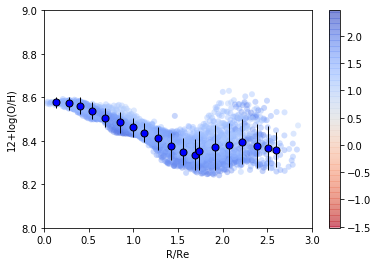

In [327]:
R=df['R'].values
d4000=df['D4000'].values
OH=df['OH'] .values
Sgas=df['Sgas'] .values
log_c=df['EW_Ha'] .values
#log_c=np.log10(np.abs(c))
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(R, OH, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.4,edgecolor='none',cmap=cm)

binx , minx , maxx= 0.15,0,3.5
X, Y, eY = binning(R,OH, binx , minx , maxx )
p1 = plt.errorbar(X, Y, yerr= eY, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )

OH_smooth=np.interp(R,X,Y)
Delta_OH=OH-OH_smooth
axes.set_xlabel('R/Re')
axes.set_ylabel('12+log(O/H)')
axes.set_xlim([0,3])
axes.set_ylim([8,9])
fig.colorbar(figure, ax=axes)


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/usr/lib/python3/dist-packages/ipykernel_launcher.py

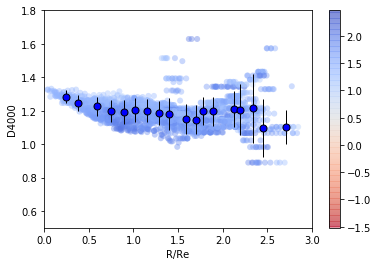

In [328]:
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(R, d4000, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.4,edgecolor='none',cmap=cm)

binx , minx , maxx= 0.15,0,3.5
X, Y, eY = binning(R,d4000, binx , minx , maxx )
p1 = plt.errorbar(X, Y, yerr= eY, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )
axes.set_xlabel('R/Re')
axes.set_ylabel('D4000')
d4000_smooth=np.interp(R,X,Y)
Delta_d4000=d4000-d4000_smooth
#print (Delta_OH)
axes.set_xlim([0,3])
axes.set_ylim([0.5,1.8])
fig.colorbar(figure, ax=axes)

/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:186: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/usr/lib/python3/dist-packages/ipykernel_launcher.py:44: RuntimeWarning: invalid value encountered in greater_equal
/usr/lib/python3/dist-packages/ipykernel_launcher.py

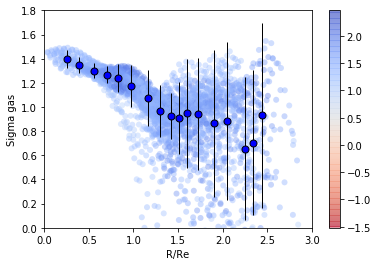

In [329]:
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(R, Sgas, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.4,edgecolor='none',cmap=cm)

binx , minx , maxx= 0.15,0,3.5
X, Y, eY = binning(R,Sgas, binx , minx , maxx )
p1 = plt.errorbar(X, Y, yerr= eY, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )
axes.set_xlabel('R/Re')
axes.set_ylabel('Sigma gas')
Sgas_smooth=np.interp(R,X,Y)
Delta_Sgas=Sgas-Sgas_smooth
#print (Delta_OH)
axes.set_xlim([0,3])
axes.set_ylim([0.0,1.8])
fig.colorbar(figure, ax=axes)

CR Delta_D4000 vs  Delta_OH= 0.1485825767092212
Coeffs lin fit Delta_D4000 vs. Delta_O/H= -0.002 0.003 0.21 0.038


/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3257: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/sanchez/.local/lib/python3.7/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


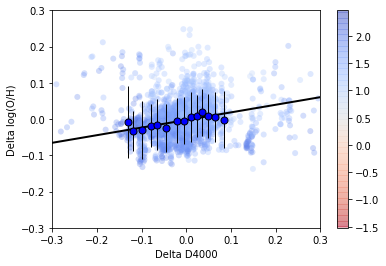

In [330]:
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(Delta_d4000, Delta_OH, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
mask = (np.isfinite(Delta_d4000)) & (np.isfinite(Delta_OH))
cr=np.corrcoef(Delta_d4000[mask],Delta_OH[mask])
print('CR Delta_D4000 vs  Delta_OH=',cr[0,1])
binx , minx , maxx= 0.02,-0.3,0.3
X, Y, eY = binning(Delta_d4000, Delta_OH,binx , minx , maxx )
p1 = plt.errorbar(X, Y, yerr= eY, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )
funct3    = lambda x,a,b: a + b * x
START=[0.01,0.01]
mask=np.isfinite(X) & np.isfinite(Y) & np.isfinite(eY)
pa1, ea1  = optimize.curve_fit(funct3, X[mask], Y[mask], sigma=eY[mask], p0 = START )
print('Coeffs lin fit Delta_D4000 vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))
x_fit=np.linspace(-0.4, 0.4, 10)
y_fit=funct3(x_fit,pa1[0],pa1[1])
f1 = plt.plot(x_fit, y_fit, '-k', linewidth = 2, markerfacecolor ='black'  , color ='black' )
axes.set_xlabel('Delta D4000')
axes.set_ylabel('Delta log(O/H)')
axes.set_xlim([-0.3,0.3])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)


CR Delta_SGAS vs  Delta_OH= -0.23985911619418168
Coeffs lin fit Delta_SGAS vs. Delta_O/H= -0.003 0.002 -0.064 0.009


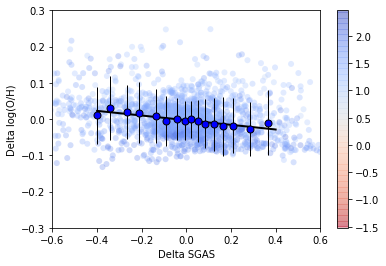

In [331]:
fig, axes = plt.subplots()
cm = plt.cm.get_cmap('coolwarm_r')
figure=axes.scatter(Delta_Sgas, Delta_OH, c=log_c, vmin=-1.52,vmax=2.47,alpha=0.3,edgecolor='none',cmap=cm)
mask = (np.isfinite(Delta_Sgas)) & (np.isfinite(Delta_OH))
cr=np.corrcoef(Delta_Sgas[mask],Delta_OH[mask])
print('CR Delta_SGAS vs  Delta_OH=',cr[0,1])
binx , minx , maxx= 0.05,-0.4,0.4
X, Y, eY = binning(Delta_Sgas, Delta_OH,binx , minx , maxx )
p1 = plt.errorbar(X, Y, yerr= eY, markersize = 7, markerfacecolor ='blue', markeredgecolor = 'black', fmt = 'o', ecolor='black', elinewidth = 1, label = 'O3N2-M13' )
funct3    = lambda x,a,b: a + b * x
START=[0.01,0.01]
mask=np.isfinite(X) & np.isfinite(Y) & np.isfinite(eY)
pa1, ea1  = optimize.curve_fit(funct3, X[mask], Y[mask], sigma=eY[mask], p0 = START )
print('Coeffs lin fit Delta_SGAS vs. Delta_O/H=',round(pa1[0],3),round(np.sqrt(np.diag(ea1))[0],3),round(pa1[1],3),round(np.sqrt(np.diag(ea1))[1],3))
x_fit=np.linspace(-0.4, 0.4, 10)
y_fit=funct3(x_fit,pa1[0],pa1[1])
f1 = plt.plot(x_fit, y_fit, '-k', linewidth = 2, markerfacecolor ='black'  , color ='black' )
axes.set_xlabel('Delta SGAS')
axes.set_ylabel('Delta log(O/H)')
axes.set_xlim([-0.6,0.6])
axes.set_ylim([-0.3,0.3])
fig.colorbar(figure, ax=axes)
